In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from basic_lib.evaluation import cv_performance
from basic_lib.stats import oddsRatio

from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
df = pd.read_csv('./data/catalunia_dataset_v5.csv')
print(df.shape[0])
df.head()

15149


,a_patientid,patientsex,age,height,weight,bmi,albumine_min,albumine_max,potassium_min,potassium_max,...,dbp_max,fr_min,fr_max,diabetes,heart_failure,hypertension,chronic_kidney_disease,crrt_time,aki_stage,crrt_24_134_h
0,1000109,0,50,160,80,31,2.68,2.68,2.50,3.20,...,75.00,16.0,21.00,NaN,NaN,NaN,NaN,NaN,2.0,0
1,1002635,0,80,160,60,23,3.32,3.32,4.77,4.77,...,95.15,14.0,16.65,1.0,NaN,NaN,NaN,NaN,1.0,0
2,1002875,1,50,160,90,35,2.15,2.15,4.33,4.33,...,53.75,19.0,20.00,NaN,NaN,NaN,NaN,NaN,2.0,0
3,1003452,1,80,160,60,23,2.39,2.39,3.20,4.40,...,94.10,16.0,25.00,NaN,NaN,NaN,NaN,NaN,2.0,0
4,1003886,0,70,170,110,38,2.53,2.53,3.92,3.92,...,71.80,15.0,26.00,1.0,NaN,1.0,NaN,NaN,2.0,0


## Preprocessing

In [3]:
from typing import Tuple

class DataProcessing():
    """
    Simple class that perform the pre-processing needed to run the analysis on Catalunia data
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def transform(self) -> pd.DataFrame:
        columns = pd.Series(self.df.columns.tolist())
        bools = columns.apply(lambda x: False if x.find('_')<0 else (True if x.split('_')[1]=='min' else False))
        predictors = columns[bools].apply(lambda x: x.split('_')[0])

        for pred in predictors:
            self.df[f'{pred}_delta'] = self.df[f'{pred}_max'] - self.df[f'{pred}_min']
            self.df = self.df.drop(columns=[f'{pred}_max'])

        return self.df

In [4]:
processor = DataProcessing(df)
df_proc = processor.transform()
df_proc

,a_patientid,patientsex,age,height,weight,bmi,albumine_min,potassium_min,haematocrit_min,ph_min,...,ph_delta,bun_delta,scr_delta,bicarbonate_delta,spo2_delta,hr_delta,sbp_delta,mbp_delta,dbp_delta,fr_delta
0,1000109,0,50,160,80,31,2.68,2.50,29.0,7.46,...,0.03,0.0,0.0,2.1,7.00,20.00,15.25,17.50,20.00,5.00
1,1002635,0,80,160,60,23,3.32,4.77,41.7,NaN,...,NaN,0.0,0.0,NaN,3.00,11.55,73.50,67.60,55.70,2.65
2,1002875,1,50,160,90,35,2.15,4.33,24.7,NaN,...,NaN,0.0,0.0,NaN,5.00,24.00,56.25,27.50,19.25,1.00
3,1003452,1,80,160,60,23,2.39,3.20,23.7,7.35,...,0.16,0.0,0.0,7.8,3.00,79.00,55.35,31.95,25.10,9.00
4,1003886,0,70,170,110,38,2.53,3.92,27.8,7.46,...,0.00,0.0,0.0,NaN,10.00,25.00,67.40,36.80,27.60,11.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15144,6802633,0,70,170,100,35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.00,17.00,47.90,22.50,20.00,7.50
15145,6819849,1,60,160,90,35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.00,15.00,28.20,29.20,33.00,9.00
15146,6840246,1,60,160,90,35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.85,25.00,49.20,43.25,43.80,0.00
15147,6936861,0,40,170,80,28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.00,39.90,18.00,10.60,13.00,13.80


In [5]:
df_X = df_proc.drop(columns=['a_patientid','crrt_24_134_h'])

df_aki = pd.get_dummies(df_proc.aki_stage.astype(int), dtype='int64')
df_aki.columns = [f'akiStage_{i}' for i in df_aki.columns]

df_X = df_X.drop(columns=['aki_stage'])
df_X = pd.concat([df_X, df_aki], axis=1)

binary_cols = ['patientsex','chronic_kidney_disease','diabetes','hypertension','heart_failure'] + df_aki.columns.tolist()
continous_cols = list(set(df_X.columns).difference(binary_cols))

In [5]:
# cols = df_X.columns[np.where(df_X.columns.isin(continous_cols))[0]].tolist()
# f, axs = plt.subplots(len(cols), len(cols), figsize=(20,20), facecolor='white')

# for i,i_col in enumerate(cols):
#     for j,j_col in enumerate(cols):
#         if (i != j) and (j < i):
#             _ = axs[i,j].scatter(df[j_col], df[i_col], s=3, c=df.crrt_24_134_h, alpha=0.4)
#             _ = axs[i,j].set_xticks([])
#             _ = axs[i,j].set_yticks([])
#         else:
#             _ = axs[i,j].hist(df[i_col])
#             _ = axs[i,j].set_xticks([])
#             _ = axs[i,j].set_yticks([])
#         if j > i:
#             _ = axs[i,j].remove()
#         if i == len(cols)-1:
#             _ = axs[i,j].set_xlabel(j_col, rotation=30, ha='right')
#         elif j == 0:
#             _ = axs[i,j].set_ylabel(i_col, rotation=60, ha='right')


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df):
    X = df.copy()
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [7]:
df_featSel = df_X.copy()
df_featSel.loc[:, binary_cols] = df_featSel.loc[:, binary_cols].fillna(0)
medians = df_featSel.loc[:, continous_cols].median()
df_featSel.loc[:, continous_cols] = df_featSel.loc[:, continous_cols].fillna(medians)
cols = df_featSel.columns.tolist()
cols.remove('akiStage_1')
# cols.remove('akiStage_3')
cols.remove('weight')
cols.remove('spo2_min')
cols.remove('mbp_min')
cols.remove('mbp_delta')
cols.remove('crrt_time')
df_vif = compute_vif(df_featSel.loc[:, cols].dropna()) #
df_vif.sort_values(by='VIF', ascending=False)

,Variable,VIF
7,ph_min,2.219983
28,sbp_delta,2.193067
29,dbp_delta,2.099442
22,ph_delta,2.054998
13,dbp_min,2.029960
12,sbp_min,1.953721
2,height,1.778965
0,patientsex,1.681073
32,akiStage_3,1.677788
31,akiStage_2,1.528277


In [9]:
binary_cols = list(set(cols).difference(continous_cols))
continous_cols = list(set(cols).difference(binary_cols))
df_X = df_X.loc[:, binary_cols+continous_cols]

## Logistic Regression

### Feature Selection

In [10]:
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer
X = df_X.copy()
X.loc[:, binary_cols] = X.loc[:, binary_cols].fillna(0)
X = X.values
y = df.crrt_24_134_h.values

si = SimpleImputer()
X_ = si.fit_transform(X)

kfold = StratifiedKFold(n_splits=5)
pvals = []
for idx_train,_ in kfold.split(X, y):
    _, p = f_classif(X_[idx_train], y[idx_train])
    pvals.append(np.where(p < 0.001, 1, 0))
pvals = pd.DataFrame(pvals, columns=df_X.columns)
pvals.sum().sort_values(ascending=False)

akiStage_2                5
ph_delta                  5
bicarbonate_min           5
potassium_delta           5
ph_min                    5
bun_delta                 5
dbp_min                   5
bicarbonate_delta         5
sbp_min                   5
bun_min                   5
haematocrit_delta         5
hr_min                    5
albumine_min              5
haematocrit_min           5
age                       5
akiStage_3                5
chronic_kidney_disease    5
fr_min                    5
spo2_delta                4
potassium_min             2
scr_min                   1
sbp_delta                 1
height                    0
fr_delta                  0
bmi                       0
scr_delta                 0
heart_failure             0
hr_delta                  0
patientsex                0
hypertension              0
diabetes                  0
dbp_delta                 0
albumine_delta            0
dtype: int64

In [11]:
psum = pvals.sum()
feat = psum[psum==5].index.tolist()
feat

['akiStage_2',
 'akiStage_3',
 'chronic_kidney_disease',
 'age',
 'haematocrit_min',
 'fr_min',
 'ph_delta',
 'hr_min',
 'albumine_min',
 'haematocrit_delta',
 'bun_min',
 'sbp_min',
 'bicarbonate_delta',
 'dbp_min',
 'bun_delta',
 'ph_min',
 'potassium_delta',
 'bicarbonate_min']

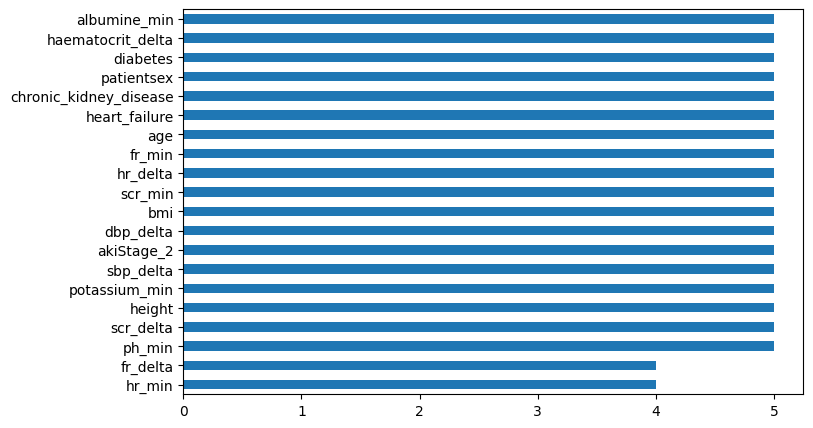

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

X = df_X.values
y = df.crrt_24_134_h.values

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    RobustScaler()
)

transformer = ColumnTransformer(
    [
        ('continous', numeric_transformer, np.where(df_X.columns.isin(continous_cols))[0]),
        ('binary', SimpleImputer(fill_value=0), np.where(df_X.columns.isin(binary_cols))[0]),
    ],
)

mdl = LGBMClassifier(
    max_depth=3,
    num_leaves=12,
    n_estimators=200,
    learning_rate=1e-2,
    class_weight='balanced',
    random_state=17,
    n_jobs=-1,
)

pipe = Pipeline([
    ('sc', transformer),
    ('sm', SMOTE(random_state=43)),
    ('mdl', mdl)
])

kfold = StratifiedKFold(n_splits=5)
cv_feat_importance = []
for idx_train,idx_test in kfold.split(X, y):
    pipe.fit(X[idx_train], y[idx_train])
    cv_feat_importance.append(np.where(pipe['mdl'].feature_importances_>0, 1, 0))
features = pd.DataFrame(cv_feat_importance, columns=df_X.columns).sum()
_ = features.sort_values()[-20:].plot(kind='barh', figsize=(8,5))

### Odds Ratio

In [13]:
df_X[feat]

,akiStage_2,akiStage_3,chronic_kidney_disease,age,haematocrit_min,fr_min,ph_delta,hr_min,albumine_min,haematocrit_delta,bun_min,sbp_min,bicarbonate_delta,dbp_min,bun_delta,ph_min,potassium_delta,bicarbonate_min
0,1,0,NaN,50,29.0,16.0,0.03,57.0,2.68,4.0,21.777,92.75,2.1,55.00,0.0,7.46,0.7,25.1
1,0,0,NaN,80,41.7,14.0,NaN,60.0,3.32,0.0,12.495,70.35,NaN,39.45,0.0,NaN,0.0,NaN
2,1,0,NaN,50,24.7,19.0,NaN,63.0,2.15,5.9,14.994,87.50,NaN,34.50,0.0,NaN,0.0,NaN
3,1,0,NaN,80,23.7,16.0,0.16,81.0,2.39,3.3,44.625,114.75,7.8,69.00,0.0,7.35,1.2,17.5
4,1,0,NaN,70,27.8,15.0,0.00,69.0,2.53,1.2,23.205,65.80,NaN,44.20,0.0,7.46,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15144,0,1,NaN,70,NaN,16.5,NaN,64.0,NaN,NaN,NaN,102.40,NaN,52.50,NaN,NaN,NaN,NaN
15145,0,0,NaN,60,NaN,14.0,NaN,65.0,NaN,NaN,NaN,103.00,NaN,63.40,NaN,NaN,NaN,NaN
15146,0,0,NaN,60,NaN,23.0,NaN,52.0,NaN,NaN,NaN,88.20,NaN,44.60,NaN,NaN,NaN,NaN
15147,0,0,NaN,40,NaN,12.2,NaN,85.0,NaN,NaN,NaN,101.00,NaN,65.40,NaN,NaN,NaN,NaN


/tmp/ipykernel_295/1559267658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd.chronic_kidney_disease = asd.chronic_kidney_disease.fillna(0)


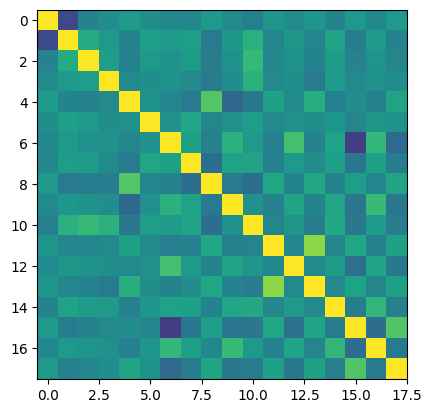

In [14]:
f, ax = plt.subplots()

asd = df_X[feat]
asd.chronic_kidney_disease = asd.chronic_kidney_disease.fillna(0)
img = asd.corr()

_ = ax.imshow(img, vmin=-1, vmax=1)

In [15]:
# feat = list(set(features[features>=5].index.tolist()))
psum = pvals.sum()
feat = psum[psum==5].index.tolist()
# feat.remove('akiStage_3')

df_odds = df_X.loc[:, feat]
df_odds.chronic_kidney_disease = df_odds.chronic_kidney_disease.fillna(0)
im = SimpleImputer(strategy='median')
X_odds = im.fit_transform(df_odds)
odds = oddsRatio(
    X_odds, df.crrt_24_134_h.values,
    columnnames=feat, n_iterations=100,
    solver='sag', ratio=0.3
    )

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behav

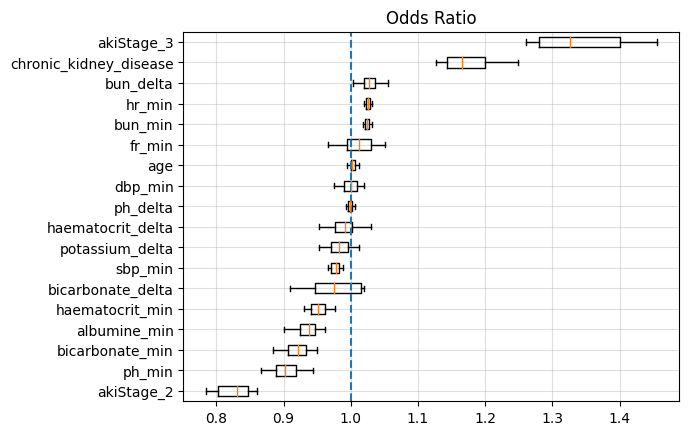

In [16]:
f, ax = plt.subplots(facecolor='w')
feat_order = odds.mean().sort_values().index
_ = ax.boxplot(odds.loc[:, feat_order], vert=False, whis=(5, 95), showfliers=False)
_ = ax.grid(alpha=0.4)
_ = ax.set_yticklabels(feat_order)
_ = ax.axvline(1, linestyle='--')
_ = ax.set_title('Odds Ratio')
# _ = ax.set_xlim((0,2))

### Cross-validation

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

X = df_X.values # df_tr.values #
y = df.crrt_24_134_h.values

# feat = set(features[features>=4].index.tolist())
selected_continous = list(set(feat).intersection(continous_cols))
selected_binary = list(set(feat).intersection(binary_cols))

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    RobustScaler()
)

transformer = ColumnTransformer(
    [
        ('continous', numeric_transformer, np.where(df_X.columns.isin(selected_continous))[0]),
        ('binary', SimpleImputer(fill_value=0), np.where(df_X.columns.isin(selected_binary))[0]),
    ],
)

mdl = LogisticRegression(
    penalty='elasticnet',
    random_state=17,
    solver='saga',
    max_iter=100,
    # fit_intercept=False,
)

# pos = df.crrt_24_134_h.sum()
# neg = df.shape[0] - pos
# bias = np.log([pos/neg])

# mdl.intercept_ = bias

pipe = Pipeline([
    ('sc', transformer),
    ('sm', SMOTE()),
    ('mdl', mdl)
])

params = {
    'mdl__C': Real(1e-8, 1e+8, prior='log-uniform'),
    'mdl__class_weight': Categorical([None,'balanced']),
    'mdl__l1_ratio': Real(1e-5, 1, prior='uniform'),
}

kfold = StratifiedKFold(n_splits=5)

search = BayesSearchCV(
    pipe,
    params,
    cv=kfold,
    scoring='f1_macro',
    random_state=17,
)
_ = search.fit(X,y)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [36]:
search.best_estimator_['mdl'].get_params()

{'C': 0.0006499076611980818,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 1e-05,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': 17,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [37]:
res = cv_performance(search.best_estimator_, X, y, k=5) # , mode='youdens'

c:\Users\PIERANDREA\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\PIERANDREA\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\PIERANDREA\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\PIERANDREA\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [38]:
res[0].stack().groupby(level=1).median()

Test               Train          
                  0         1         0         1
F1         0.898739  0.182635  0.907779  0.190399
Precision  0.996791  0.101667  0.996569  0.106836
Recall     0.818028  0.882353  0.833586  0.874074

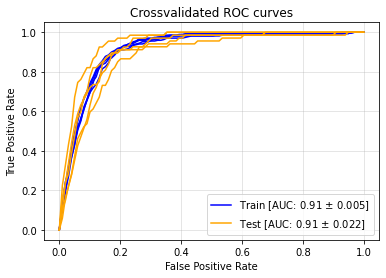

In [39]:
from basic_lib.utils import plot_rocs

_ = plot_rocs(res)

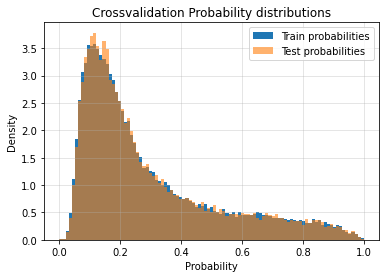

In [40]:
from basic_lib.utils import probability_inspection

_ = probability_inspection(res)

In [ ]:
# TODO 
# Feature importance
# Share feature used

## LightGBM

In [ ]:
mdl = LGBMClassifier(
    max_depth=1,
    num_leaves=2,
    n_estimators=100,
    class_weight='balanced',
    random_state=17,
    n_jobs=-1,
)

params = {
    #'num_leaves': Integer(5, 10),
    #'max_depth': Integer(3, 5),
    'learning_rate': Real(1e-6, 1e-1, prior='log-uniform'),
    #'n_estimators': Integer(10, 50),
    'reg_alpha': Real(1e-6, 1e+6, prior='log-uniform'),
    'reg_lambda': Real(1e-6, 1e+6, prior='log-uniform'),
}

kfold = StratifiedKFold(n_splits=5)

search_xgb = BayesSearchCV(
    mdl,
    params,
    cv=kfold,
    scoring='f1_macro',
    random_state=17,
)
# _ = search.fit(X,y)

# search.best_estimator_

In [ ]:
lgbm_perf, lgbm_rocs = cv_performance(search_xgb, X, y, k=5) # , mode='youdens'
lgbm_perf.stack().groupby(level=1).median()

In [ ]:
f, ax = plt.subplots()

for r in lgbm_rocs['train']:
    _ = ax.plot(r['fpr'], r['tpr'], 'b')
    
for r in lgbm_rocs['test']:
    _ = ax.plot(r['fpr'], r['tpr'], 'orange')
    
plt.show()